In [1]:
import pandas as pd
df= pd.read_csv("/content/spell_autocomplete_dataset1.csv")

df['misspelled'] = df['misspelled'].str.lower().str.strip()
df['correct'] = df['correct'].str.lower().str.strip()
df.drop_duplicates(inplace = True)
df.head()

,misspelled,correct,autocomplete_input,correct_word
0,sloger,slogger,slo,slogger
1,pjhotosurveying,photosurveying,pho,photosurveying
2,forrpeak,forepeak,for,forepeak
3,contraceptivre,contraceptive,con,contraceptive
4,liina,lina,lin,lina


In [2]:
#NLP preprocessing using regular expression module
import re

columns = ['misspelled' , 'correct' , 'autocomplete_input' , 'correct_word']
# vectorized using "str"
df[columns] = df[columns].apply(lambda col: col.str.lower().str.replace(r'[^a-z]','', regex =True).str.strip())
df.dropna(inplace =True)
df = df[df['misspelled'].str.len()>0]
print("cleaned data")
print(df.head())

cleaned data
        misspelled         correct autocomplete_input    correct_word
0           sloger         slogger                slo         slogger
1  pjhotosurveying  photosurveying                pho  photosurveying
2         forrpeak        forepeak                for        forepeak
3   contraceptivre   contraceptive                con   contraceptive
4            liina            lina                lin            lina


In [3]:
#autocomplete implementation
from collections import defaultdict
import pandas as pd
#prefix to word dictionary
autocomplete_dictionary = defaultdict(lambda: defaultdict(int))
for _, row in df.iterrows():
  prefix = row['autocomplete_input']
  word = row['correct_word']
  autocomplete_dictionary[prefix][word] += 1
# k =3 to get top 3 similar predictions
def autocomplete(prefix, k =3):
  if prefix in autocomplete_dictionary:
    sorted_words = sorted(autocomplete_dictionary[prefix].items(),key = lambda x: x[1],reverse =True)
    return[word for word , _ in sorted_words[:k]]
  return []

autocomplete_results = []
for _, row in df.head(10).iterrows():
  prefix = row['autocomplete_input']
  predicted = autocomplete(prefix , k=3)
  autocomplete_results.append((prefix, predicted , row['correct_word']))

autocomplete_df = pd.DataFrame(autocomplete_results, columns=['prefix','predicted top 3','actual'])
print("autocomplete:")
print(autocomplete_df)

autocomplete:
  prefix                                    predicted top 3          actual
0    slo                        [sloom, slogger, slowhound]         slogger
1    pho  [photochemistry, photosurveying, photoheliometer]  photosurveying
2    for                 [forward, formativeness, foreloop]        forepeak
3    con               [contractive, conusant, contaminant]   contraceptive
4    lin                          [lineolated, linga, lina]            lina
5    sta                [stalkingly, stampery, staggerwort]       statehood
6    ina      [inalterably, inamissibility, inadvisability]    inaffability
7    win                 [winddog, windowpeeper, winterize]        winberry
8    imp                    [impolitely, impanate, imputer]     impersonize
9    cur             [curmudgeonish, current, curarization]          curate


In [8]:
#autocorrect
import pandas as pd
import re
from collections import Counter

#tokenizing data
def clean_text(text):
  return re.sub(r'[^a-z]', '',str(text).lower())
def words(text):
  return re.findall(r'\w+',text.lower())

corpus_text = ''.join(df['correct_word'].dropna().astype(str))
words = Counter(words(corpus_text))

def probability(word):
  return words[word]/sum(words.values())

def correction(word):
  candidates = known([word]) or known(edits1(word)) or [word]
  return max(candidates, key= probability)

def known(words_list):
  return set(w for w in words_list if w in words)

def edits1(word):
  letters = 'abcdefghijklmnopqrstuvwxyz'
  splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
  deletes = [L +R[1:] for L,R in splits if R]
  transposes  =[L+R[1] +R[0]+R[2:] for L,R in splits if len(R) > 1]
  replaces = [L+c +R[1:] for L,R in splits if R for c in letters]
  inserts = [L +c +R for L,R in splits for c in letters]
  return set (deletes+transposes+replaces+inserts)

results=[]
for _, row in df.head(10).iterrows():
  misspelled = clean_text(row['misspelled'])
  actual = clean_text(row['correct_word'])
  predicted = correction(misspelled)
  results.append((misspelled,predicted,actual))

results_dataframe = pd.DataFrame(results,columns=['misspelled','predicted', 'actual'])
print("autocorrect :")
print(results_dataframe)

autocorrect :
        misspelled        predicted          actual
0           sloger           sloger         slogger
1  pjhotosurveying  pjhotosurveying  photosurveying
2         forrpeak         forrpeak        forepeak
3   contraceptivre   contraceptivre   contraceptive
4            liina            liina            lina
5        syatehood        syatehood       statehood
6    inaffabillity    inaffabillity    inaffability
7        wwinberry        wwinberry        winberry
8     impersponize     impersponize     impersonize
9          curaate          curaate          curate


In [24]:
#metrics
top_k = 3
correct_count = 0
for _, row in df.head(200).iterrows():
  prefix = row['autocomplete_input']
  actual = row['correct_word']
  predictions = autocomplete(prefix, k = top_k)
  if actual in predictions:
    correct_count +=1

accuracy = correct_count/100
print(f"top-{top_k} Accuracy: {accuracy:.2f}")

top-3 Accuracy: 0.85


In [31]:
def autocorrect(input_word):
  return spell_dict.get(input_word, input_word)
correct_count = 0
total = 10
for _, row in df.head(total).iterrows():
  typo = row['misspelled']
  actual = row['correct_word']
  predicted = simple_autocorrect(typo)
  if predicted == actual:
      correct_count +=1
  accuracy = correct_count/total
  print(f"autocorrect accuracy: {accuracy:.2f}")


autocorrect accuracy: 0.10
autocorrect accuracy: 0.20
autocorrect accuracy: 0.30
autocorrect accuracy: 0.40
autocorrect accuracy: 0.50
autocorrect accuracy: 0.60
autocorrect accuracy: 0.70
autocorrect accuracy: 0.80
autocorrect accuracy: 0.90
autocorrect accuracy: 1.00


In [45]:
#user experience
import pandas as pd
import random
spell_dictionary  = dict(zip(df['misspelled'],df['correct_word']))

def simple_autocorrect(word):
  return spell_dictionary.get(word,word)

def feedback(predicted,actual):
  if predicted == actual:
    return 'satisfied'
  elif predicted in actual or actual in predicted:
      return 'okay'
  else:
        return 'not satisfied'

feedback_rows =[]
for  _, row in df.head(10).iterrows():
      typo = row['misspelled']
      actual = row['correct_word']
      predicted = simple_autocorrect(typo)
      user_feedback = feedback(predicted , actual)

      feedback_rows.append({
       'typo' : typo,
       'predicted' : predicted,
       'actual' : actual,
       'user feedback' : user_feedback

       })
feedback_dataframe  = pd.DataFrame(feedback_rows)
feedback_summary = feedback_dataframe['user feedback'].value_counts(normalize = True)*100
print("feedback :")
print(feedback_dataframe.head(10))

print("user feedback:")
print(feedback_summary.round(2))

feedback :
              typo       predicted          actual user feedback
0           sloger         slogger         slogger     satisfied
1  pjhotosurveying  photosurveying  photosurveying     satisfied
2         forrpeak        forepeak        forepeak     satisfied
3   contraceptivre   contraceptive   contraceptive     satisfied
4            liina            lina            lina     satisfied
5        syatehood       statehood       statehood     satisfied
6    inaffabillity    inaffability    inaffability     satisfied
7        wwinberry        winberry        winberry     satisfied
8     impersponize     impersonize     impersonize     satisfied
9          curaate          curate          curate     satisfied
user feedback:
user feedback
satisfied    100.0
Name: proportion, dtype: float64


In [57]:
#model comparison
import pandas as pd
import re
import time
from collections import Counter
from difflib import get_close_matches

corpus = ''.join(df['correct_word'].astype(str).tolist())
def get_words(text):
  return re.findall(r'\w+', text.lower())

words = Counter(get_words(corpus))
vocab = list(set(words.keys()))

spell_dictionary = dict(zip(df['misspelled'],df['correct_word']))
def autocorrect(word):
     return spell_dictionary.get(word, word)

def probability(word):
     return words[word]/ sum (words.values())

def known (words_list):
     return set(w for w in words_list if w in words)

def edits1(word):
  letters = 'abcdefghijklmnopqrstuvwxyz'
  splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
  deletes = [L +R[1:] for L,R in splits if R]
  transposes  =[L+R[1] +R[0]+R[2:] for L,R in splits if len(R) > 1]
  replaces = [L+c +R[1:] for L,R in splits if R for c in letters]
  inserts = [L +c +R for L,R in splits for c in letters]
  return set (deletes+transposes+replaces+inserts)

def norvig_probability(word):
  candidates = known([word]) or known (edits1(word)) or [word]
  return max(candidates , key = probability)

def levensthtein(word):
  matches = get_close_matches(word , vocab , n=1,cutoff = 0.7)
  return matches[0] if matches else word

def model (model_func,model_name):
  correct = 0
  total=len(df)
  start= time.time()
  for _, row in df.iterrows():
     predicted = model_func(str(row['misspelled']))
     actual = str(row['correct_word'])
     if predicted == actual:
        correct +=1


  end =time.time()
  accuracy = correct/total
  elapsed = end- start
  return{
        'model' : model_name,
        'accuracy' : round(accuracy,3),
        'time' : round(elapsed,2)

    }

results= []
results.append(model(autocorrect, 'simple dictionary'))
results.append(model(norvig_probability , 'norvig probability'))
results.append(model(levensthtein , 'levensthtein'))

results_df = pd.DataFrame(results)
print("model comparision")
print(results_df)

model comparision
                model  accuracy  time
0   simple dictionary     0.999  1.38
1  norvig probability     0.000  7.99
2        levensthtein     0.000  1.83


/tmp/ipython-input-61-2445037478.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x='model', y='accuracy', data =df_visualization, palette='Greens_r')


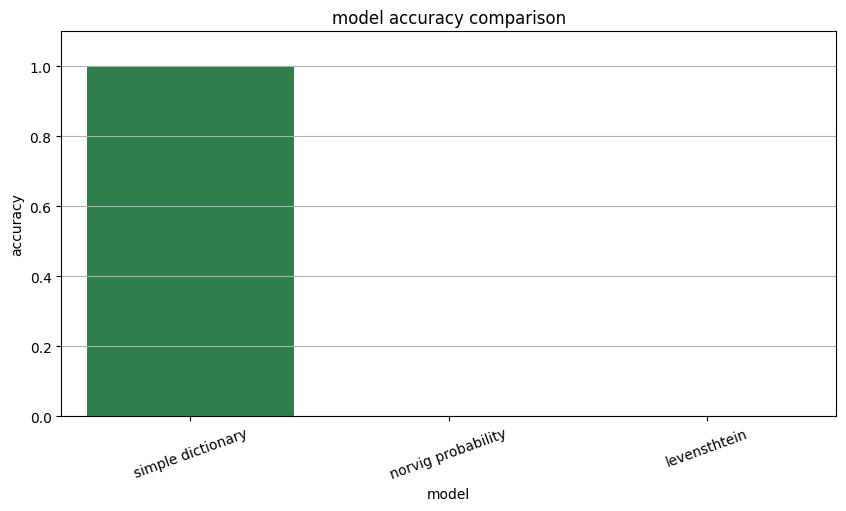

/tmp/ipython-input-61-2445037478.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='time', data = df_visualization, palette='Blues_r')


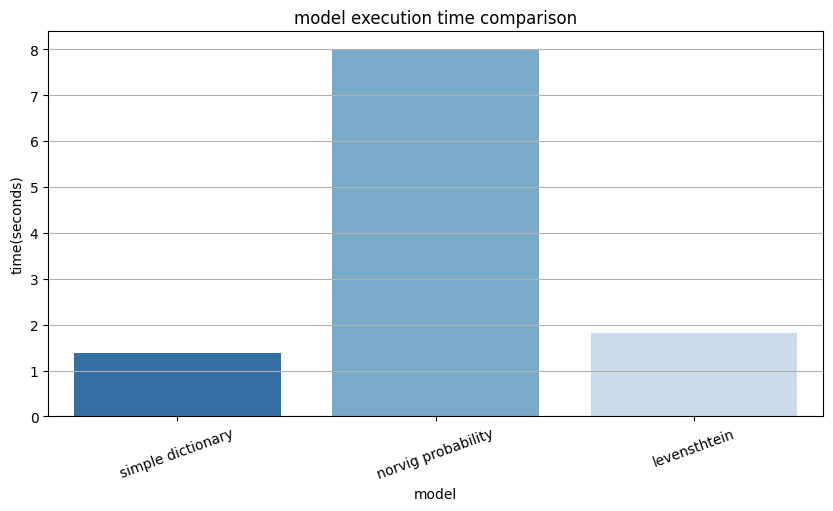

In [61]:
#visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = {'model' : ['simple dictionary', 'norvig probability', 'levensthtein'], 'accuracy' : [0.999, 0.0, 0.0], 'time' : [1.38,7.99,1.83]}
df_visualization = pd.DataFrame(data )

plt.figure(figsize=(10,5))
sns.barplot( x='model', y='accuracy', data =df_visualization, palette='Greens_r')
plt.title('model accuracy comparison')
plt.ylabel('accuracy')
plt.ylim(0,1.1)
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='model', y='time', data = df_visualization, palette='Blues_r')
plt.title('model execution time comparison')
plt.ylabel('time(seconds)')
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.show()